## Devesh Pathak


### Introduction

In this study, a cohort of 50 patients were administered a treatment for their tumors. Their tumors were also biopsied and then sequenced using whole exome sequencing. The goal of this study is to identify genes that are differentially associated with patients' response to the treatment.

### Initial steps



In [1]:
#Importing relevant modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 

C:\Users\deves\AppData\Local\Temp\ipykernel_20032\3247908908.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


I decided to start by loading in the sample data tsv for later use, since I knew I would need to reference it down the line. I also opted to record the total number of responders and non-responders in a list called response_cts for later use. I understand that these are known quantities in the context of this problem, but I wanted to write code that would require minimal modification for use with a generic dataset (albeit assuming a similar naming scheme).

In [195]:
#dataframe of patient info 

patient_df=pd.read_csv("./sample-information.tsv",sep="\t")

#Store Responder vs Non-Responder counts in a list [Responder ct, Non-Responder ct]
response_cts=patient_df.shape[0]-patient_df[patient_df.Response=="Responder"].shape[0]
response_cts=[response_cts,patient_df.shape[0]-response_cts]



Next, I built a data frame to unify all the data from the maf files to save time and processing (avoids rereading maf files). To accomplish this, I created an initial dataframe by reading in patient-0's maf file, and filtered out all rows representing silent mutations. Next, I added a patient ID column so that mutations and their source patients were still tracable in the final dataframe. Finally, I selected the columns from patient-0's maf data [Hugo_Symbol, Protein_Change, Patient_ID] and the patient information dataframe above [Patient_ID, Response, Nonsynonymous_mutations_Per_Mb] and merged the two into a single dataframe on the Patient_ID column. Reducing the working dataframe down to just the relevant columns was done to help save memory. The resulting dataframe contained the following columns:

|Hugo_Symbol|Protein_Change|Patient_ID|Response|Nonsynonymous_mutations_per_Mb|
|-----------|--------------|----------|--------|------------------------------|

I iterated through the remaining maf files, repeating the steps above and concatenating the result to my working dataframe, eventually unifying all the data from the 50 maf files while tracking sample identity.

In [204]:
# Build larger data frame

#Initialize dataframe using patient zero maf and filter out silent mutations
df=pd.read_csv("./mafs/Patient-0.somatic.snvs.maf", sep="\t")
df=df[df.Variant_Classification != "Silent"]

#Create column for patient ID
df["Patient_ID"]=["Patient-0"]*df.shape[0]

#Merge with patient data set, reduce down to columns relevant for this pipeline
df=df[["Hugo_Symbol","Protein_Change","Patient_ID"]].merge(
    patient_df[["Patient_ID","Response","Nonsynonymous_mutations_per_Mb"]])

#display(df)

# For loop repeats steps above for each other maf file and then concatenates 
# their data to working dataframe
for i in range(1, patient_df.shape[0]):

    # Read in maf file and remove rows representing silent mutations
    temp_df=pd.read_csv("./mafs/Patient-%d.somatic.snvs.maf" % (i), sep="\t")
    temp_df=temp_df[temp_df.Variant_Classification != "Silent"]

    # Create patient ID column
    temp_df["Patient_ID"]=["Patient-%d" % (i)]*temp_df.shape[0]

    # Take selections of columns from maf dataframe and patient dataframe,
    # merge on patient ID field
    temp_df=temp_df[["Hugo_Symbol","Protein_Change","Patient_ID"]].merge(
        patient_df[["Patient_ID","Response","Nonsynonymous_mutations_per_Mb"]])

    df=pd.concat([df,temp_df], axis=0)

display(df.head())
print(df.shape)

,Hugo_Symbol,Protein_Change,Patient_ID,Response,Nonsynonymous_mutations_per_Mb
0,AMOT,p.Q612E,Patient-0,Non-Responder,6.77
1,SEMA6D,p.A676T,Patient-0,Non-Responder,6.77
2,PRR12,p.S1126C,Patient-0,Non-Responder,6.77
3,ZNF253,p.V277I,Patient-0,Non-Responder,6.77
4,MEF2C,p.S313L,Patient-0,Non-Responder,6.77


(11247, 5)


### Finding the most frequent mutation

To find the most frequent individual mutation, the Hugo_Symbol, Protein_Change, and Patient_ID columns of the working dataframe were selected and then grouped by the Hugo_Symbol and Protein_change. Doing so reduced the columns down to sets of patients expressing specific mutations. Next, the number of patient IDs in each group were counted to determine mutation frequencies. Finally, the rows were sorted by frequency (descending).

The top 15 most frequently occuring mutations are displayed by the code cell below. Note that the patient ID column is equivalent to the number of patients expressing the mutation.

In [197]:
# Select columns of working dataframe, groups by unique mutations
# (Hugo symbol and protein change), counts the number of patient
# IDs in each group, sorts and displays top 15 indices

display(df[["Hugo_Symbol","Protein_Change","Patient_ID"]]                
        .groupby(["Hugo_Symbol","Protein_Change"])
        .count()
        .sort_values(by="Patient_ID", ascending=False).iloc[:15,:])


,,Patient_ID
Hugo_Symbol,Protein_Change,
ERBB4,p.S1289A,14
ERBB3,p.H228Q,5
PIK3CA,p.E545K,5
ERBB4,p.Q707E,5
MAP2K1,p.F53L,4
RXRA,p.S330F,4
TYRO3,p.L819M,4
ERBB3,p.M91I,4
ERBB4,p.E317K,4


### Assessing whether mutations to certain genes were overrepresented among Responders vs Non-Responders

To assess whether mutations to specific genes were enriched in responders or non-responders, I opted to use Fisher's exact test. I chose Fisher's over chi squared because chi squared is less appropriate for smaller sample sizes.

To construct the contingency table for Fisher's, I first had to find the number of patients with at least one mutation in each gene. 

This was accomplished by iterating through all unique hugo symbols (genes) represented in the dataframe. For each gene, I selected the rows in the dataframe with the same hugo symbol (i.e. the set of rows representing mutations in that gene), grouped the rows by response, and then counted the number of unique patient IDs in each group. Checking for uniqueness was important to prevent double counting patients with multiple mutations to the same gene. Doing so provided counts of patients with at least one mutation in a given gene with respect to whether they responded to treatment.

Once these frequencies were collected, Fisher's test was run with respect to the current gene. The contingency table was constructed as follows

| Given a Gene | Responder | Non Responder|
| ---------| -----------| ----------|
| Has Mutation| no. patients | no. patients |
| Lacks Mutation| no. patients| no. patients|

The results of the Fisher's tests were stored in a dictionary whose keys were the hugo symbols and values were Fisher statistic, p value, and the total number of patients with a mutation in that gene. 

In [198]:
# Iterates through unique mutated genes in dataframe, counts how many unique patients
# have at least one mutation in that gene, and performs Fisher's test with respect to 
# each gene.

# Dictionary for storing results of Fisher's tests
fish_dict={}

# iterate through unique genes in dataframe

for gene in df["Hugo_Symbol"].unique():

    # Select rows representing mutations to current gene, group by treatment
    # response, and count unique patients (to eliminate chance of double counting)

    temp_df=df[df.Hugo_Symbol==gene]
    temp_df=temp_df[["Patient_ID","Response"]].groupby(["Response"]).nunique()
    
    # Collects responder/non-responder mutation frequencies
    # if none are found set to zero

    responder_ct = (temp_df.loc["Responder"].Patient_ID 
                    if ("Responder") in temp_df.index else 0)
    
    non_responder_ct = (temp_df.loc["Non-Responder"].Patient_ID 
                        if ("Non-Responder") in temp_df.index else 0)

    # Set up contingency table and run Fisher's test, recording result in variable

    fish_tab=[[responder_ct, non_responder_ct],
              [response_cts[0]-responder_ct, response_cts[1]-non_responder_ct]]
    
    res=scipy.stats.fisher_exact(fish_tab,alternative="two-sided")
    
    # Add to dictionary. Key is current gene/hugo symbol. Value is
    # Fisher statistic, p-value, and total no. patients with mutation

    fish_dict.update({gene:(res[0], res[1], 
                           responder_ct+non_responder_ct)})
    
# Convert dataframe to dictionary and display top ten results
Fisher_df=pd.DataFrame.from_dict(fish_dict,orient="index",
                              columns=["statistic","p_value","total_freq"])

display(Fisher_df.sort_values("p_value").iloc[:10,:])

,statistic,p_value,total_freq
ERCC2,inf,0.001631,9
AKAP9,inf,0.022290,6
MACF1,inf,0.022290,6
HERC1,inf,0.022290,6
MROH2B,inf,0.022290,6
HECTD1,inf,0.022290,6
KMT2C,9.333333,0.048797,8
DNAH3,inf,0.050152,5
COL6A6,inf,0.050152,5
ANK2,inf,0.050152,5


The resulting dictionary was converted into a data frame, and sorted by p value (ascending). The top ten indices after sorting are displayed above. The most significantly enriched mutated gene was ERCC2, which I will discuss more below.

### Plot of -log(p values) vs number of mutated patients 

I opted to use the negative log of the p values on my y axis so that there was increased separation between points with significance. It also results in more significant results appearing higher on the y axis, which may be more intuitive. I also reduced the marker size so that it was more clear which positions had a large number of very close/overlapping points. To further aid interpretation, I labeled the most significant result identified earlier, and inluded a line corresponding to p = 0.05. I opted to only label ERCC2 due to the larger gap in significance between it and other points, and because there are numerous overlapping points in this plot which would hinder effective labeling.



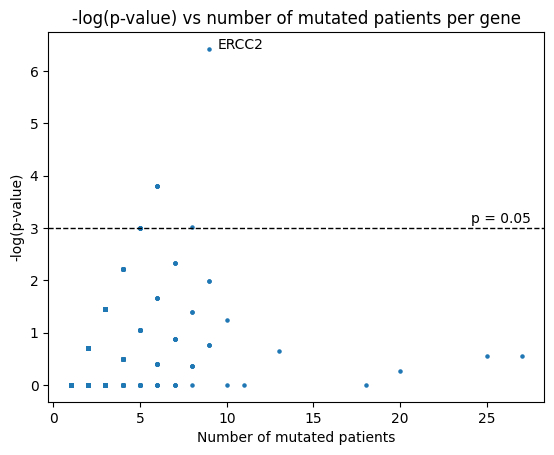

In [199]:
#Scatterplot of number of mutated patients and -log p value

fig, ax=plt.subplots()
ax.set_xlabel("Number of mutated patients")
ax.set_ylabel("-log(p-value)")
ax.set_title("-log(p-value) vs number of mutated patients per gene")
ax.scatter(Fisher_df.total_freq,
           -1*np.log(Fisher_df.p_value), s=5)

# Add line showing p = 0.05 threshold
ax.axhline(-1*np.log(0.05), color='k', linestyle='dashed', linewidth=1)
ax.text(ax.get_xlim()[1]*0.85, -1*np.log(0.05)+0.1, "p = 0.05",color="k")

#Label most significant result
ax.text(Fisher_df.loc["ERCC2"].total_freq+0.5,
        -1*np.log(Fisher_df.loc["ERCC2"].p_value),"ERCC2")

plt.show()



### Wild Type vs Mutant samples with respect to ERCC2

The next step was to find whether each patient was wild type (wt) or mutant with respect to our most significant result (ERCC2) and then record their Nonsynonymous mutations per Mb.

To build both series, two empty lists were initialized (one for wt, one for mutant). I then grouped the dataframe by Patient_ID, checked whether a row existed where the Hugo symbol was ERCC2 for each patient, and added the patient's nonsynonymous mutations/Mb to the appropriate list.

In [200]:
# For each patient, check if their maf file contains a row for ERCC2. If it does, 
# append their nonsynonymous mutations/Mb from patient dataframe to the mutant list. 
# Otherwise append it to wt list.

wt=[]
mutant=[]

for patient in df[["Hugo_Symbol","Patient_ID",
                   "Nonsynonymous_mutations_per_Mb"]].groupby(["Patient_ID"]):

    if "ERCC2" in patient[1].Hugo_Symbol.values:
        mutant.append(patient[1].Nonsynonymous_mutations_per_Mb[0])
    else:
        wt.append(patient[1].Nonsynonymous_mutations_per_Mb[0])



These lists were used to create overlapping violin and boxplots of Nonsynonymous mutations/mb for wt vs mutant patients (below) to visualize the distributions for both populations. Visually, the distribution of non synonymous mutation frequency for wild type patients sits lower than that of mutant patients (aside from a couple of outliers).Additionally, a Wilcoxon rank sum test was conducted to determine whether there was a significant difference in the nonsynonymous mutations per Megabase. I chose the Wilcoxon ranked sum test over a T test because a T test assumes a normal distribution which did not appear satisfied by the data's distribution. A Mann Whitney U test would also be appropriate for this data, but I chose the Wilcoxon test because I have seen it be used more frequently in the papers I have read.

It found that there **was a significant difference** in the number of nonsynonymous mutations per Megabase between wild type and mutatant patients (p=0.0016)

Wilcoxon ranked sum results:
	Statistic = -3.16 
	p-value = 0.00160


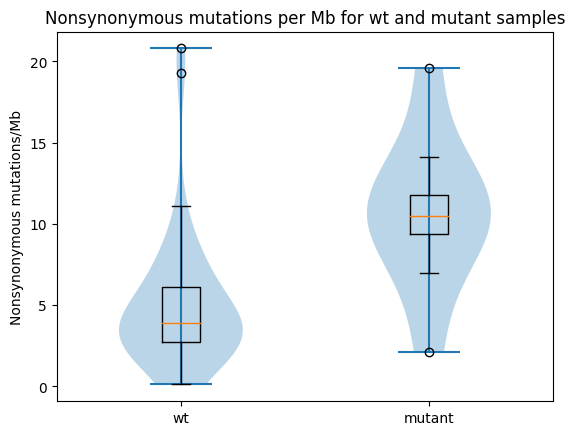

In [201]:
# Create boxplot of Nonsynonymous mutations/Mb for wt vs mutant patients.

fig, ax=plt.subplots()
ax.violinplot([wt,mutant])
ax.boxplot([wt,mutant])
ax.set_ylabel("Nonsynonymous mutations/Mb")
ax.set_xticklabels(["wt","mutant"])
ax.set_title("Nonsynonymous mutations per Mb for wt and mutant samples")
#print(len(wt),len(mutant))


# Wilcoxon ranked sum test to determine whether there is a significant 
# difference between groups.

Wilcox_result=scipy.stats.ranksums(wt, mutant)

print("Wilcoxon ranked sum results:\n\tStatistic = {stat:.2f} \n\tp-value = {val:.5f}"
      .format(stat=Wilcox_result[0], val=Wilcox_result[1]))

### Conclusions from tests

In this study, we determined that nonsynonymous mutations in ERCC2 were most enriched between patients that responded to treatment and patients that did not. Additionally, we determined that there was a significant difference in the number of nonsynonymous mutations among patients with a mutation in ERCC2 compared to patients without one. Given this information, the next logical step would be to interrogate the function of ERCC2.

ERCC2 codes for a protein called XPD, which is a part of the Transcription Factor II Human (TFIIH) complex. The TFIIH complex is involved in initiating transcription, and is also involved in DNA repair via the Nucleotide Exision Repair pathway ([Medline Plus](https://medlineplus.gov/genetics/gene/ercc2/), [Genecards](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERCC2)). Impairments to DNA repair being conducive to increased mutation frequency makes intuitive sense, as it can lead to additional mutations and allow them to persist. This connection also corroborates well with prior research, as defects in this ERCC2 have also been associated with multiple disorders, including one that makes individuals more prone to skin cancer known as Xeroderma pigmentosum, group D ([NCBI ERCC2 page](https://www.ncbi.nlm.nih.gov/gene/2068), [NCBI Xenoderma pigmentosum page](https://www.ncbi.nlm.nih.gov/medgen/75656)).


### Expansion and Improvement:

Obviously, this study would benefit from a larger sample size, as this data is quite thin. Apart from that, an interesting direction to expand this analysis would be to interrogate the data on the level of functionally related sets of genes (maybe GSEA or something similar). Doing so would allow us to see if certain pathways were more likely to be mutated in responders vs non-responders. Doing so may better characterize the types of disruptions for which the treatment is effective compared to analysis at the level of individual genes. 

An improvement to the study may be to require a sufficient number of patients to have a mutation before testing it using Fisher's. I had this thought because I decided to look at the significance threshold for part four (the Fisher's test) after using Bonferroni correction to account for multiple testing. While this did not effect the most significant mutation (hence why I opted to discuss it in the conclusion), I found that the resultant significance threshold seemed very low/demanding and was curious as to how many samples could realistically be filtered out prior to testing (e.g. a gene that only had nonsynonymous mutation/s in a single sample). 

Below, I have compiled some statistics and a histogram of sample sizes per gene. These use the same dataframe used for the Fisher's test above, so a sample size of one means that only one patient in the cohort had one or more nonsynonymous mutations for that gene. 

Number of unique genes tested:  6927
Bonferroni adjusted p value assuming all genes tested and initial
significance threshold of p < 0.05: p < 7.218e-06

Average frequency of all genes: 1.53
Median frequency of all genes: 1.0
Total number of genes with one observation: 4657
Proportion of genes with one observation: 0.67


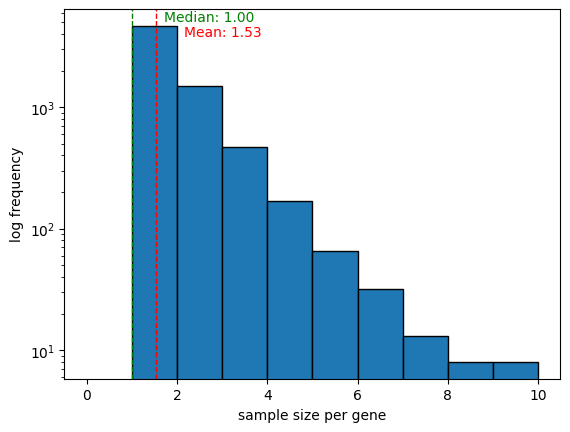

In [202]:
#Dimensions of freq dataframe and Bonferroni adjusted threshold for initial tests

print("Number of unique genes tested: ", Fisher_df.shape[0])

print("Bonferroni adjusted p value assuming all genes tested and", 
      "initial\nsignificance threshold of p < 0.05: p < {val:.3e}\n"
      .format(val=0.05/Fisher_df.shape[0]))

#summary statistics for number of observations

print("Average frequency of all genes: {val:.2f}"
      .format(val=np.mean(Fisher_df.total_freq)))

print("Median frequency of all genes:", np.median(Fisher_df.total_freq))

#total number and proportion of genes with less than two observations across cohort

print("Total number of genes with one observation:", 
      Fisher_df[Fisher_df.total_freq<=1].shape[0])

print("Proportion of genes with one observation: {val:.2f}"
      .format(val= Fisher_df[Fisher_df.total_freq<=1].shape[0]/Fisher_df.shape[0]))

# Histogram of total number of observations

fig, ax=plt.subplots()
ax.hist(Fisher_df.total_freq,range=(0,10), log=True, edgecolor="k")
ax.set_ylabel("log frequency")
ax.set_xlabel("sample size per gene")

#annotate mean
ax.axvline(np.mean(Fisher_df.total_freq), color='r', linestyle='dashed', linewidth=1)
ax.text(np.mean(Fisher_df.total_freq)*1.4, ax.get_ylim()[1]*0.6, 'Mean: {:.2f}'
        .format(np.mean(Fisher_df.total_freq)),color="r")

#annotate median
ax.axvline(np.median(Fisher_df.total_freq), color='g', linestyle='dashed', linewidth=1)
ax.text(np.median(Fisher_df.total_freq)*1.7, ax.get_ylim()[1]*0.8, 'Median: {:.2f}'
        .format(np.median(Fisher_df.total_freq)),color="g")

plt.show()

Based on these results, two thirds of the genes respresented in the maf files only had one corresponding patient with an observed mutation/mutations. As a result, testing these genes individually is very unlikely to produce relevant results. In filtering them out of the genes tested, both the amount of computation and the penalty on the significance threshold would decrease.

Below, I calculate the Bonferonni corrected significance threshold (assuming inital significance threshold of 0.05) if genes with frequency <=1 were not tested.

In [203]:
print("Bonferroni adjusted p value assuming only genes with >1 observation tested",
      "\nand initial significance threshold of p < 0.05: p < {val:.3e}".format(
          val = 0.05/(Fisher_df.shape[0]-Fisher_df[Fisher_df.total_freq<=1].shape[0])))


Bonferroni adjusted p value assuming only genes with >1 observation tested 
and initial significance threshold of p < 0.05: p < 2.203e-05


While that threshold is still demanding, it is more achievable by an order of magnitude. Additionally, this is the safest subset to remove alongside a relatively conservative correction procedure in Bonferroni. I understand that these optimizations do not impact the pipeline associated with this problem, but I thought it was worth attention nonetheless. 



### Works Cited

ERCC2 ERCC excision repair 2, TFIIH core complex helicase subunit [Homo sapiens (human)] - Gene - NCBI. (2024, December 3). Www.ncbi.nlm.nih.gov. 
    <br>   https://www.ncbi.nlm.nih.gov/gene/2068

ERCC2 Gene - GeneCards | ERCC2 Protein | ERCC2 Antibody. (n.d.). Genecards.org. 
    <br>   Retrieved December 9, 2024, from https://www.genecards.org/cgi-bin/carddisp.pl?gene=ERCC2

ERCC2 gene: MedlinePlus Genetics. (2010, May 1). Medlineplus.gov. 
    <br>   https://medlineplus.gov/genetics/gene/ercc2/

Xeroderma pigmentosum, group D (Concept Id: C0268138) - MedGen - NCBI. (n.d.). Nih.gov. 
    <br>   Retrieved December 9, 2024, from https://www.ncbi.nlm.nih.gov/medgen/75656